In [1]:
import sys

import torch  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import matplotlib.pyplot as plt
import ot
import importlib

from pydil.utils.Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

from pydil.utils.igmm import IGMM

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\pydil\utils\igmm.py:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.conf['function'] is 'log':
c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\py

In [2]:
dataset = np.load('toy_affine_dataset.npy')

In [3]:
dataset.shape

(6000, 16)

In [4]:
X = dataset[:, :-2]
y = dataset[:, -2]
d = dataset[:, -1]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [5]:
X.shape, y.shape, d.shape

((6000, 14), (6000,), (6000,))

In [6]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [7]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [8]:
combined_arrays = list(zip(Xt, yt))

random.seed(0)
# Shuffle the combined arrays
random.shuffle(combined_arrays)

# Unzip the shuffled arrays back into separate arrays
Xt, yt = zip(*combined_arrays)
Xt = torch.stack(Xt, axis=0)
yt = torch.stack(yt, axis=0)

In [9]:
n_samples = 1000
batch_size = 200
n_atoms = 3
n_classes = 10

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==n_domains-1)[0], :], y[np.where(d==n_domains-1)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)
dim_reduction = 3

In [11]:
range_data = np.mean(np.max(X[np.where(d!=n_domains-1)[0], :], axis=0) - np.min(X[np.where(d!=n_domains-1)[0], :], axis=0))

dim_reduction = 3
n_gaussians = 10
OGMM = Online_GMM(
    n_components=n_gaussians, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction
OGMM.get_GMM()

c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\pydil\utils\Online_GMM.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  return (2*np.pi)**(-len(x)/2) * np.linalg.det(cov)**(-1/2) * np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean))


[[tensor(0.2375),
  tensor(203.4833),
  tensor([-19.3115,  -2.8940,   0.1735]),
  tensor([[ 9.4094,  1.6900, -0.2652],
          [ 1.6900,  0.3329, -0.1267],
          [-0.2652, -0.1267,  0.3293]])],
 [tensor(6.8664e-44),
  tensor(0.5136),
  tensor([42.7763, -3.2264,  0.2769]),
  tensor([[ 4.6705, -0.4039, -0.2306],
          [-0.4039,  6.2923, -0.7689],
          [-0.2306, -0.7689,  0.5086]])],
 [tensor(0.1007),
  tensor(150.2229),
  tensor([ 5.7023,  1.4055, -4.3826]),
  tensor([[ 9.7155,  2.2852, -0.5931],
          [ 2.2852,  0.5396, -0.1349],
          [-0.5931, -0.1349,  0.0764]])],
 [tensor(5.6052e-45),
  tensor(0.2866),
  tensor([28.2980,  3.5967,  0.4615]),
  tensor([[ 4.9022,  0.7924, -0.3745],
          [ 0.7924,  1.5894, -0.1539],
          [-0.3745, -0.1539,  0.8048]])],
 [tensor(0.0777),
  tensor(118.6365),
  tensor([27.6206, -4.6831,  1.1295]),
  tensor([[ 2.4245e+01, -2.0527e+00, -7.2581e-02],
          [-2.0527e+00,  2.2667e-01, -1.4600e-03],
          [-7.2581e-02, -1

In [12]:
sklearn_GMM = GaussianMixture(n_components=n_gaussians, random_state=0)
sklearn_GMM.fit(Xt)

GaussianMixture(n_components=10, random_state=0)

In [13]:
model = IGMM(min_components=10, max_step_components=10, max_components=20)

n_batch = 20
i=0
while i < Xt.shape[0]-n_batch:
    model.train(Xt[i:i+n_batch, :])
    i += n_batch


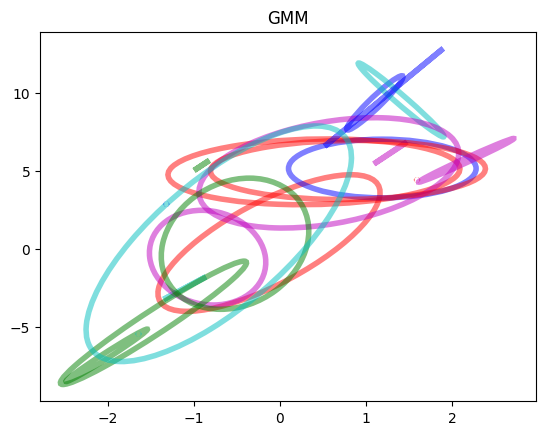

In [15]:
fig1, ax1 = plt.subplots(1,1)
ax1 = model.plot_gmm_projection(0,1, axes=ax1)


In [16]:
np.sum(OGMM.score_samples(Xt, dimension_reduction=True))

-5228.695552624859

In [17]:
sklearn_GMM = GaussianMixture(n_components=n_gaussians, random_state=0)
sklearn_GMM.fit(Xt)
np.sum(sklearn_GMM.score_samples(Xt))

52632.458970572465

In [18]:
np.sum(model.score_samples(Xt))

36535.83374243613